## Step 1. Setup and Library Imports

In [ ]:
import pandas as pd
import nltk
import re
import string
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("VADER Sentiment Analyzer is already installed.")
except ImportError:
    !pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("VADER Sentiment Analyzer installed successfully.")

# Mount Google Drive to access files
drive.mount('/content/drive')

## Step 2. Common Data Loading

In [6]:
def parse(path):
    """
    A generator function to parse a gzipped JSON file line by line.
    """
    with gzip.open(path, 'rt', encoding='utf-8') as g:
        for line in g:
            yield json.loads(line)

def get_df(path):
    """
    Converts parsed JSON data into a Pandas DataFrame.
    """
    return pd.DataFrame(list(parse(path)))

# Load the dataset from Google Drive
# Make sure the file path is correct
try:
    df = get_df('/content/drive/MyDrive/Amazon_Recommender/data/raw/Electronics_5.json.gz')
    print("Successfully loaded the dataset.")
    print("Original DataFrame shape:", df.shape)
except Exception as e:
    print(f"Error loading data: {e}")
    # Create an empty DataFrame to avoid errors in subsequent code
    df = pd.DataFrame()

Successfully loaded the dataset.
Original DataFrame shape: (6739590, 12)


## Step 3. Sentiment Analysis on Cleaned Text
- In this approach, the text is first thoroughly cleaned and then analyzed for sentiment.

### 3.1. Data Preparation and Text Cleaning

In [10]:
if not df.empty:
    # Create a copy of the dataframe with necessary features
    reviews_df_1 = df[['reviewerID', 'asin', 'reviewText', 'overall']].copy()

    # Remove rows with missing values in the reviewText column
    reviews_df_1.dropna(subset=['reviewText'], inplace=True)
    print("Shape after dropping NA:", reviews_df_1.shape)

    # Download required NLTK data packages
    # 'stopwords': a list of common words (e.g., "a", "the") to filter out.
    # 'wordnet': a lexical database required for lemmatization (reducing words to their base form).
    # 'punkt': a data resource for tokenization (splitting text into words).
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('punkt_tab')

    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        """
        Cleans and preprocesses a raw text string for NLP tasks.
        Steps:
        1. Converts text to lowercase.
        2. Removes all punctuation.
        3. Removes numerical digits.
        4. Tokenizes the text into words.
        5. Removes stopwords and lemmatizes the remaining words.
        6. Joins words back into a single string.
        """
        # 1. Convert to lowercase
        text = text.lower()
        # 2. Remove punctuation
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        # 3. Remove numbers
        text = re.sub(r'\d+', '', text)
        # 4. Tokenize text
        words = nltk.word_tokenize(text)
        # 5. Lemmatize and remove stopwords
        cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        # 6. Join words back into a single string
        return " ".join(cleaned_words) # Corrected to join with spaces

    # Apply the cleaning function to the reviewText column
    print("\nCleaning review text...")
    reviews_df_1['cleaned_reviewText'] = reviews_df_1['reviewText'].apply(clean_text)
    print("Text cleaning complete.")
    display(reviews_df_1[['reviewText', 'cleaned_reviewText']].head())

Shape after dropping NA: (6738237, 4)

Cleaning review text...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Text cleaning complete.


,reviewText,cleaned_reviewText
0,This is the best novel I have read in 2 or 3 y...,best novel read year everything fiction beauti...
1,"Pages and pages of introspection, in the style...",page page introspection style writer like henr...
2,This is the kind of novel to read when you hav...,kind novel read time lose book day possibly we...
3,What gorgeous language! What an incredible wri...,gorgeous language incredible writer last life ...
4,I was taken in by reviews that compared this b...,taken review compared book leopard promised bi...


### 3.2. Sentiment Score Calculation and Visualization (on Cleaned Text)


--- Sample of Reviews with Sentiment Scores (from Cleaned Text) ---


,overall,sentiment_score,cleaned_reviewText
0,5.0,0.9601,best novel read year everything fiction beauti...
1,3.0,0.9452,page page introspection style writer like henr...
2,5.0,0.9761,kind novel read time lose book day possibly we...
3,5.0,0.9794,gorgeous language incredible writer last life ...
4,3.0,0.9840,taken review compared book leopard promised bi...


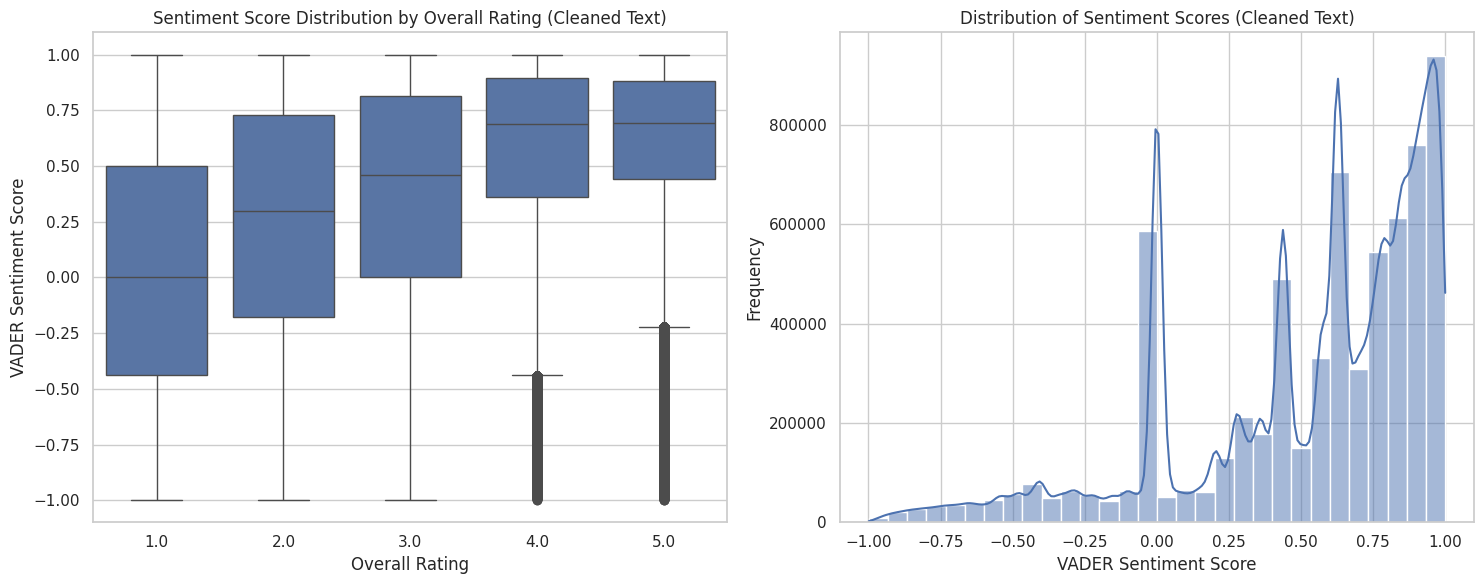


--- Correlation Matrix (Cleaned Text) ---
                  overall  sentiment_score
overall          1.000000         0.372422
sentiment_score  0.372422         1.000000

Processed data from Analysis 1 saved to: /content/drive/MyDrive/Amazon_Recommender/data/processed/03_df_with_sentiment_1.csv


In [11]:
if 'reviews_df_1' in locals():
    # Initialize the VADER sentiment intensity analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Define a function to extract the 'compound' sentiment score
    def get_sentiment_score(text):
        return analyzer.polarity_scores(text)['compound']

    # Apply the function to the cleaned review text
    reviews_df_1['sentiment_score'] = reviews_df_1['cleaned_reviewText'].apply(get_sentiment_score)

    print("\n--- Sample of Reviews with Sentiment Scores (from Cleaned Text) ---")
    display(reviews_df_1[['overall', 'sentiment_score', 'cleaned_reviewText']].head())

    # --- Visualization ---
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Subplot 1: Box plot of sentiment scores vs. overall rating
    sns.boxplot(x='overall', y='sentiment_score', data=reviews_df_1, ax=axes[0])
    axes[0].set_title('Sentiment Score Distribution by Overall Rating (Cleaned Text)')
    axes[0].set_xlabel('Overall Rating')
    axes[0].set_ylabel('VADER Sentiment Score')

    # Subplot 2: Histogram of all sentiment scores
    sns.histplot(reviews_df_1['sentiment_score'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Sentiment Scores (Cleaned Text)')
    axes[1].set_xlabel('VADER Sentiment Score')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # --- Correlation and Data Export ---
    correlation = reviews_df_1[['overall', 'sentiment_score']].corr()
    print("\n--- Correlation Matrix (Cleaned Text) ---")
    print(correlation)

    # Save the processed DataFrame to a new CSV file
    output_path = '/content/drive/MyDrive/Amazon_Recommender/data/processed/03_df_with_sentiment_1.csv'
    reviews_df_1.to_csv(output_path, index=False)
    print(f"\nProcessed data from Analysis 1 saved to: {output_path}")

## Step 4. Sentiment Analysis on Raw Text
- This second approach skips the detailed text cleaning and applies VADER directly to the original review text.

### 4.1. Data Preparation and Sentiment Calculation (on Raw Text)

In [12]:
if not df.empty:
    # Create a fresh copy of the dataframe
    reviews_df_2 = df[['reviewerID', 'asin', 'reviewText', 'overall']].copy()
    reviews_df_2.dropna(subset=['reviewText'], inplace=True)
    print("\n--- Starting Analysis 2: Using Raw Text ---")
    print("Shape of DataFrame for Analysis 2:", reviews_df_2.shape)

    # Initialize the VADER sentiment intensity analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Define a function to extract the 'compound' sentiment score
    def get_sentiment_score(text):
        return analyzer.polarity_scores(text)['compound']

    # Apply the function directly to the raw reviewText
    reviews_df_2['sentiment_score'] = reviews_df_2['reviewText'].apply(get_sentiment_score)

    print("\n--- Sample of Reviews with Sentiment Scores (from Raw Text) ---")
    display(reviews_df_2[['overall', 'sentiment_score', 'reviewText']].head())


--- Starting Analysis 2: Using Raw Text ---
Shape of DataFrame for Analysis 2: (6738237, 4)

--- Sample of Reviews with Sentiment Scores (from Raw Text) ---


,overall,sentiment_score,reviewText
0,5.0,0.9601,This is the best novel I have read in 2 or 3 y...
1,3.0,0.8382,"Pages and pages of introspection, in the style..."
2,5.0,0.9642,This is the kind of novel to read when you hav...
3,5.0,0.9737,What gorgeous language! What an incredible wri...
4,3.0,0.9850,I was taken in by reviews that compared this b...


### 4.2. Visualization and Correlation (on Raw Text)

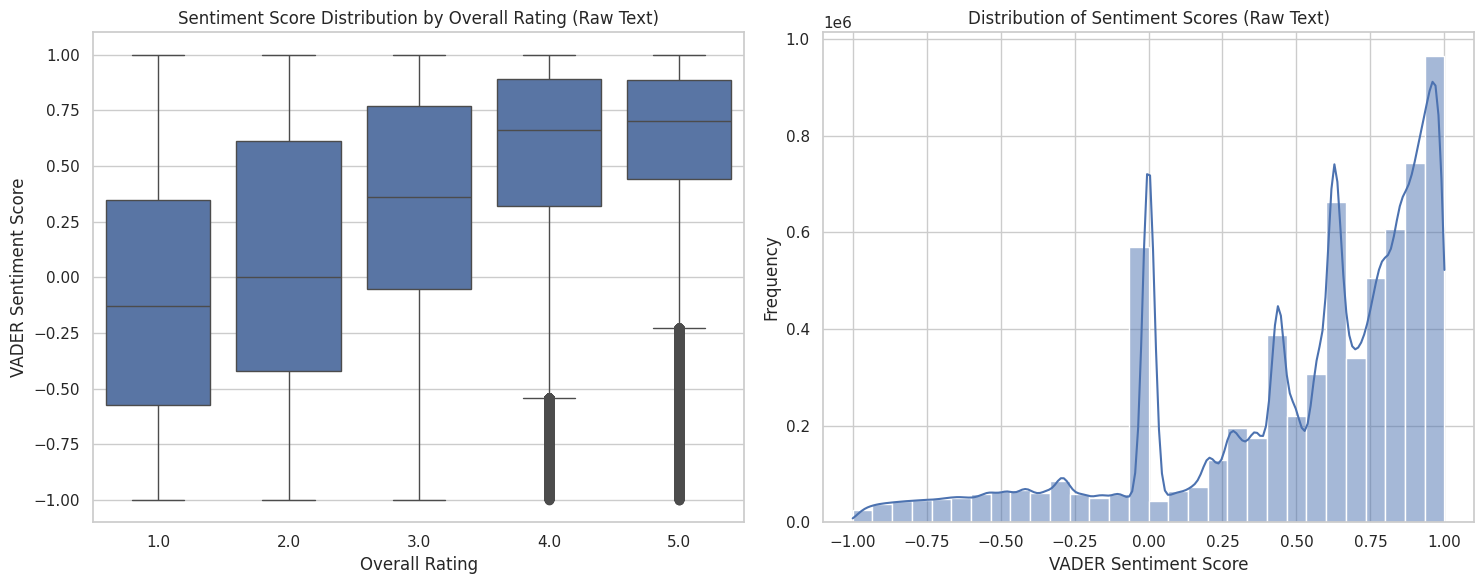


--- Correlation Matrix (Raw Text) ---
                  overall  sentiment_score
overall          1.000000         0.455738
sentiment_score  0.455738         1.000000

Processed data from Analysis 2 saved to: /content/drive/MyDrive/Amazon_Recommender/data/processed/03_df_with_sentiment_2.csv


In [13]:
if 'reviews_df_2' in locals():
    # --- Visualization ---
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Subplot 1: Box plot of sentiment scores vs. overall rating
    sns.boxplot(x='overall', y='sentiment_score', data=reviews_df_2, ax=axes[0])
    axes[0].set_title('Sentiment Score Distribution by Overall Rating (Raw Text)')
    axes[0].set_xlabel('Overall Rating')
    axes[0].set_ylabel('VADER Sentiment Score')

    # Subplot 2: Histogram of all sentiment scores
    sns.histplot(reviews_df_2['sentiment_score'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Sentiment Scores (Raw Text)')
    axes[1].set_xlabel('VADER Sentiment Score')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # --- Correlation and Data Export ---
    correlation = reviews_df_2[['overall', 'sentiment_score']].corr()
    print("\n--- Correlation Matrix (Raw Text) ---")
    print(correlation)

    # Save the processed DataFrame to a new CSV file
    output_path = '/content/drive/MyDrive/Amazon_Recommender/data/processed/03_df_with_sentiment_2.csv'
    reviews_df_2.to_csv(output_path, index=False)
    print(f"\nProcessed data from Analysis 2 saved to: {output_path}")